<a href="https://colab.research.google.com/github/byunsy/retinal-oct-classification/blob/main/Retinal_OCT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retinal OCT (Optical Coherence Topography) Classification

---



## 01. Import Necessary Packages
We first need to import several packages. We will be using TensorFlow and Keras.

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## 02. Attain Dataset from Kaggle








Firstly, pip install kaggle.

In [4]:
!pip install -q kaggle

Also import google.colab to upload the kaggle.json file which can be downloaded manually from your kaggle account.

In [ ]:
from google.colab import files
files.upload()

Make a new directory and copy the kaggle.json file to that directory. This is required to download datasets.

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Make some changes to the permission settings.

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

Download the desired datasets. It is easy if you go to the dataset, and click the additional setting (three dots) and "copy API command".

In [ ]:
!kaggle datasets download -d paultimothymooney/kermany2018

Now unzip the downloaded zip folder.

In [ ]:
!unzip /content/kermany2018.zip

Delete some unnecessary folders and files from unzipped directory.

In [10]:
!rm -r /content/oct2017/

## 03. Understanding the Dataset

Firstly, create directory paths for the base directory and its main subdirectories.

In [11]:
# Create directory paths
base_dir = os.path.join(os.path.dirname('/content/kermany2018.zip'), 'OCT2017')

# Set the main directory paths
test_dir  = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')

Now, let's learn more about the number of images in each directory.

** Note that the unzipped directory has a space at the end of "OCT2017 ". Be sure to remove it (to "OCT2017") before proceeding to the next step below.

In [12]:
# A function to print number of image files in each directory
def print_dir_info():
    # Get number of images for each directory
    num_ts_norm   = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    num_ts_cnv    = len(os.listdir(os.path.join(test_dir, 'CNV')))
    num_ts_dme    = len(os.listdir(os.path.join(test_dir, 'DME')))
    num_ts_drusen = len(os.listdir(os.path.join(test_dir, 'DRUSEN')))
    num_ts = num_ts_norm + num_ts_cnv + num_ts_dme + num_ts_drusen

    num_tr_norm   = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    num_tr_cnv    = len(os.listdir(os.path.join(train_dir, 'CNV')))
    num_tr_dme    = len(os.listdir(os.path.join(train_dir, 'DME')))
    num_tr_drusen = len(os.listdir(os.path.join(train_dir, 'DRUSEN')))
    num_tr = num_tr_norm + num_tr_cnv + num_tr_dme + num_tr_drusen

    num_vl_norm   = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
    num_vl_cnv    = len(os.listdir(os.path.join(val_dir, 'CNV')))
    num_vl_dme    = len(os.listdir(os.path.join(val_dir, 'DME')))
    num_vl_drusen = len(os.listdir(os.path.join(val_dir, 'DRUSEN')))
    num_vl = num_vl_norm + num_vl_cnv + num_vl_dme + num_vl_drusen

    # Display number of images in each directory
    print("-"*50)
    print("TOTAL NUMBER OF TEST IMAGES:", num_ts)
    print("Number of NORMAL - TEST :", num_ts_norm)
    print("Number of CNV    - TEST :", num_ts_cnv)
    print("Number of DME    - TEST :", num_ts_dme)
    print("Number of DRUSEN - TEST :", num_ts_drusen, "\n")

    print("TOTAL NUMBER OF TRAIN IMAGES:", num_tr)
    print("Number of NORMAL - TRAIN :", num_tr_norm)
    print("Number of CNV    - TRAIN :", num_tr_cnv)
    print("Number of DME    - TRAIN :", num_tr_dme)
    print("Number of DRUSEN - TRAIN :", num_tr_drusen, "\n")

    print("TOTAL NUMBER OF VALIDATION IMAGES:", num_vl)
    print("Number of NORMAL - VALIDATION :", num_vl_norm)
    print("Number of CNV    - VALIDATION :", num_vl_cnv)
    print("Number of DME    - VALIDATION :", num_vl_dme)
    print("Number of DRUSEN - VALIDATION :", num_vl_drusen, "\n")

    print("-"*50)
    print("NORMAL :", num_ts_norm + num_tr_norm + num_vl_norm)
    print("CNV    :", num_ts_cnv + num_tr_cnv + num_vl_cnv)
    print("DME    :", num_ts_dme + num_tr_dme + num_vl_dme)
    print("DRUSEN :", num_ts_drusen + num_tr_drusen + num_vl_drusen)

print_dir_info()

--------------------------------------------------
TOTAL NUMBER OF TEST IMAGES: 968
Number of NORMAL - TEST : 242
Number of CNV    - TEST : 242
Number of DME    - TEST : 242
Number of DRUSEN - TEST : 242 

TOTAL NUMBER OF TRAIN IMAGES: 83484
Number of NORMAL - TRAIN : 26315
Number of CNV    - TRAIN : 37205
Number of DME    - TRAIN : 11348
Number of DRUSEN - TRAIN : 8616 

TOTAL NUMBER OF VALIDATION IMAGES: 32
Number of NORMAL - VALIDATION : 8
Number of CNV    - VALIDATION : 8
Number of DME    - VALIDATION : 8
Number of DRUSEN - VALIDATION : 8 

--------------------------------------------------
NORMAL : 26565
CNV    : 37455
DME    : 11598
DRUSEN : 8866


Notice that we only have **32** validation images and **968** test images whereas we have over **83,484** training images. To get a less extreme division in the dataset, we will first append the three sets together and then randomly split them into testing, training and validation sets with 80:10:10 ratio. 

It is important to note that we also have some imbalance in the number of images for different categories (NORMAL, CNV, DME, DRUSEN). To handle this issue, we will create class weights which we will later use in the model training process.

## 04. Data Preprocessing

In [13]:
# Move the images to corresponding directories (from val to train)
!mv /content/OCT2017/val/NORMAL/* /content/OCT2017/train/NORMAL/
!mv /content/OCT2017/val/CNV/* /content/OCT2017/train/CNV/
!mv /content/OCT2017/val/DME/* /content/OCT2017/train/DME/
!mv /content/OCT2017/val/DRUSEN/* /content/OCT2017/train/DRUSEN/

# Move the images to corresponding directories (from test to train)
!mv /content/OCT2017/test/NORMAL/* /content/OCT2017/train/NORMAL/
!mv /content/OCT2017/test/CNV/* /content/OCT2017/train/CNV/
!mv /content/OCT2017/test/DME/* /content/OCT2017/train/DME/
!mv /content/OCT2017/test/DRUSEN/* /content/OCT2017/train/DRUSEN/

Check if the files have moved.

In [14]:
print_dir_info()

--------------------------------------------------
TOTAL NUMBER OF TEST IMAGES: 0
Number of NORMAL - TEST : 0
Number of CNV    - TEST : 0
Number of DME    - TEST : 0
Number of DRUSEN - TEST : 0 

TOTAL NUMBER OF TRAIN IMAGES: 83605
Number of NORMAL - TRAIN : 26347
Number of CNV    - TRAIN : 37216
Number of DME    - TRAIN : 11422
Number of DRUSEN - TRAIN : 8620 

TOTAL NUMBER OF VALIDATION IMAGES: 0
Number of NORMAL - VALIDATION : 0
Number of CNV    - VALIDATION : 0
Number of DME    - VALIDATION : 0
Number of DRUSEN - VALIDATION : 0 

--------------------------------------------------
NORMAL : 26347
CNV    : 37216
DME    : 11422
DRUSEN : 8620


Here, we can see that some of the files have been overwritten (because they were duplicates) in the process of moving all the validation images and test images to the training directory. The sample size was decreased to **83,605** images, but this is still a quite decent size, so we'll continue with it.

We will now properly split the dataset into **80:10:10** ratio. 

In [15]:
# Creat class list
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

# For each class, divide the images into 80:10:10 ratio and move the image files
# into the corresponding class directory in test and validation sets.
for cl in classes:
  img_path = os.path.join(train_dir, cl)
  images = glob.glob(img_path + '/*.jpeg')
  
  num_train = int(round(len(images)*0.8))
  num_val   = int(round(len(images)*0.9))
  val, test = images[num_train:num_val], images[num_val:]

  for v in val:
    shutil.move(v, os.path.join(base_dir, 'val', cl))

  for t in test:
    shutil.move(t, os.path.join(base_dir, 'test', cl))

Check if we have done so successfully and accurately.

In [16]:
print_dir_info()

--------------------------------------------------
TOTAL NUMBER OF TEST IMAGES: 8361
Number of NORMAL - TEST : 2635
Number of CNV    - TEST : 3722
Number of DME    - TEST : 1142
Number of DRUSEN - TEST : 862 

TOTAL NUMBER OF TRAIN IMAGES: 66885
Number of NORMAL - TRAIN : 21078
Number of CNV    - TRAIN : 29773
Number of DME    - TRAIN : 9138
Number of DRUSEN - TRAIN : 6896 

TOTAL NUMBER OF VALIDATION IMAGES: 8359
Number of NORMAL - VALIDATION : 2634
Number of CNV    - VALIDATION : 3721
Number of DME    - VALIDATION : 1142
Number of DRUSEN - VALIDATION : 862 

--------------------------------------------------
NORMAL : 26347
CNV    : 37216
DME    : 11422
DRUSEN : 8620


We can see that the test, training, validation sets are now appropriately divdied. Let's now deal with the imbalance in the number of images in each class set using **class weights**. This dictionary of class weights will be used later on when we train the model. 

According to TF documentations, class weights "can be useful to tell the model to "pay more attention" to samples from an under-represented class." (https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [17]:
# Get number of images for each directory
num_ts_norm   = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_ts_cnv    = len(os.listdir(os.path.join(test_dir, 'CNV')))
num_ts_dme    = len(os.listdir(os.path.join(test_dir, 'DME')))
num_ts_drusen = len(os.listdir(os.path.join(test_dir, 'DRUSEN')))
num_ts = num_ts_norm + num_ts_cnv + num_ts_dme + num_ts_drusen

num_tr_norm   = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_tr_cnv    = len(os.listdir(os.path.join(train_dir, 'CNV')))
num_tr_dme    = len(os.listdir(os.path.join(train_dir, 'DME')))
num_tr_drusen = len(os.listdir(os.path.join(train_dir, 'DRUSEN')))
num_tr = num_tr_norm + num_tr_cnv + num_tr_dme + num_tr_drusen

num_vl_norm   = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_vl_cnv    = len(os.listdir(os.path.join(val_dir, 'CNV')))
num_vl_dme    = len(os.listdir(os.path.join(val_dir, 'DME')))
num_vl_drusen = len(os.listdir(os.path.join(val_dir, 'DRUSEN')))
num_vl = num_vl_norm + num_vl_cnv + num_vl_dme + num_vl_drusen

# Total number of samples in the dataset
num_samples = num_ts + num_tr + num_vl

# Number of unique classes in the dataset
num_classes = len(classes)

# Total number of samples in each class
num_cnv = num_ts_cnv + num_tr_cnv + num_vl_cnv
num_dme = num_ts_dme + num_tr_dme + num_vl_dme
num_drusen = num_ts_drusen + num_tr_drusen + num_vl_drusen
num_norm = num_ts_norm + num_tr_norm + num_vl_norm

# Compute class weights for each class
weight_cnv    = num_samples / (num_classes * num_cnv)
weight_dme    = num_samples / (num_classes * num_dme)
weight_drusen = num_samples / (num_classes * num_drusen)
weight_norm   = num_samples / (num_classes * num_norm)

# Create a dictionary to store the weights
class_weight = {0: weight_cnv, 1: weight_dme, 2: weight_drusen, 3: weight_norm}

print('Weight for CNV    (class 0): {:.2f}'.format(weight_cnv))
print('Weight for DME    (class 1): {:.2f}'.format(weight_dme))
print('Weight for DRUSEN (class 2): {:.2f}'.format(weight_drusen))
print('Weight for NORMAL (class 3): {:.2f}'.format(weight_norm))

Weight for CNV    (class 0): 0.56
Weight for DME    (class 1): 1.83
Weight for DRUSEN (class 2): 2.42
Weight for NORMAL (class 3): 0.79


## 05. Data Augmentation


We will be using a batch size of 128 and image size of 200x200. 

In [18]:
BATCH_SIZE = 128
IMG_SHAPE = 200

Create a function that will display images.

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Applying Horizontal Flip

We use ImageDataGenerator to rescale the images by 255 and then apply a random horizontal flip.

Found 66885 images belonging to 4 classes.


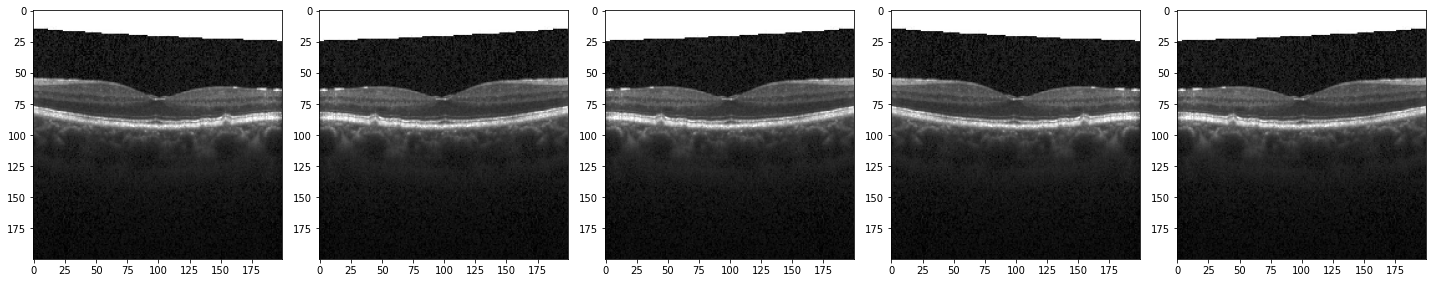

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Rotation

We use ImageDataGenerator to rescale the images by 255 and then apply a random rotation.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We use ImageDataGenerator to rescale the images by 255 and then apply a random zoom.

Found 66885 images belonging to 4 classes.


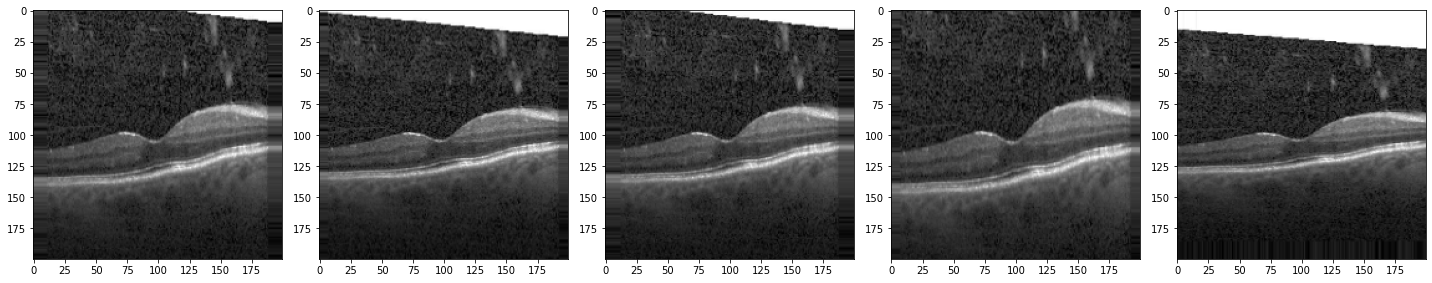

In [21]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.25)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Data Preparation

Preparing data for training images.

Found 66885 images belonging to 4 classes.


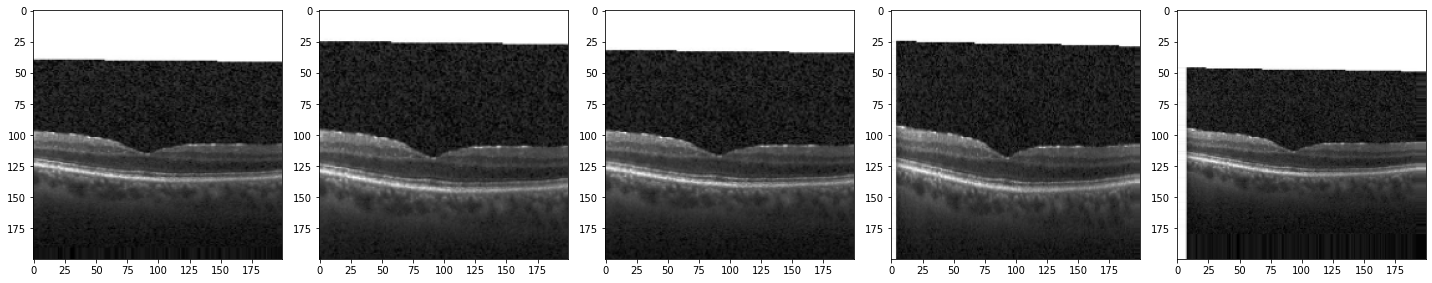

In [22]:
image_gen_train = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.25,
    horizontal_flip=True, 
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Preparing data for validation images.

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE,IMG_SHAPE),
                                                 class_mode='sparse')

Found 8359 images belonging to 4 classes.


Preparing data for testing images.

In [24]:
image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=test_dir,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='sparse')

Found 8361 images belonging to 4 classes.


## 05. Creating a CNN Model

The genereal structure is as follows:

* Three pairs of convolution and max-pooling layers
   - 16, 32, and 62 nodes in that order
   - Same Padding
   - ReLU Activation
* Flatten
* Two Dense layers
    - 512 and 2 nodes in that order
    - ReLU Activation for the first dense layer
    - Dropout rate at 0.2 at each dense layer


In [ ]:
# model = tf.keras.models.Sequential([
                                    
#     tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

#     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),

#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(4)
# ])

In [25]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])

## 06. Compiling the CNN Model

We create an "Adam Optimizer" with a learning rate of 0.001 and compile the model using this optimizer. We will be measuring accuracy and losses during the training process.

In [26]:
# Create optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 07. Training the CNN Model

We will finally train the CNN model we constructed above. Our epoch value will be 20 because we will have quite a large steps per epoch in this case. A larger value for epoch will generally produce higher accuracy, but unfortunately, the training process can take a very long time. 

In [27]:
epochs = 20

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
    class_weight=class_weight
)

Epoch 1/20
523/523 [==============================] - 819s 2s/step - loss: 1.0229 - accuracy: 0.6277 - val_loss: 0.6045 - val_accuracy: 0.7808
Epoch 2/20
523/523 [==============================] - 758s 1s/step - loss: 0.7214 - accuracy: 0.7547 - val_loss: 0.4938 - val_accuracy: 0.8185
Epoch 3/20
523/523 [==============================] - 711s 1s/step - loss: 0.5745 - accuracy: 0.8030 - val_loss: 0.4596 - val_accuracy: 0.8312
Epoch 4/20
523/523 [==============================] - 709s 1s/step - loss: 0.5010 - accuracy: 0.8282 - val_loss: 0.4209 - val_accuracy: 0.8418
Epoch 5/20
523/523 [==============================] - 707s 1s/step - loss: 0.4498 - accuracy: 0.8473 - val_loss: 0.3593 - val_accuracy: 0.8639
Epoch 6/20
523/523 [==============================] - 707s 1s/step - loss: 0.4228 - accuracy: 0.8566 - val_loss: 0.3746 - val_accuracy: 0.8722
Epoch 7/20
523/523 [==============================] - 705s 1s/step - loss: 0.4007 - accuracy: 0.8638 - val_loss: 0.3685 - val_accuracy: 0.8660

Our final accuracy for the training process was around 90.23% with a value accuracy of 90.55%, both of which seem quite decent for a five epochs. To improve the accuracy, we can further increase the number of epochs and continue the training until it gets even better.

## 08. Visualizing Model Performance

To get a better understanding of our model, let's visualize its performance. 

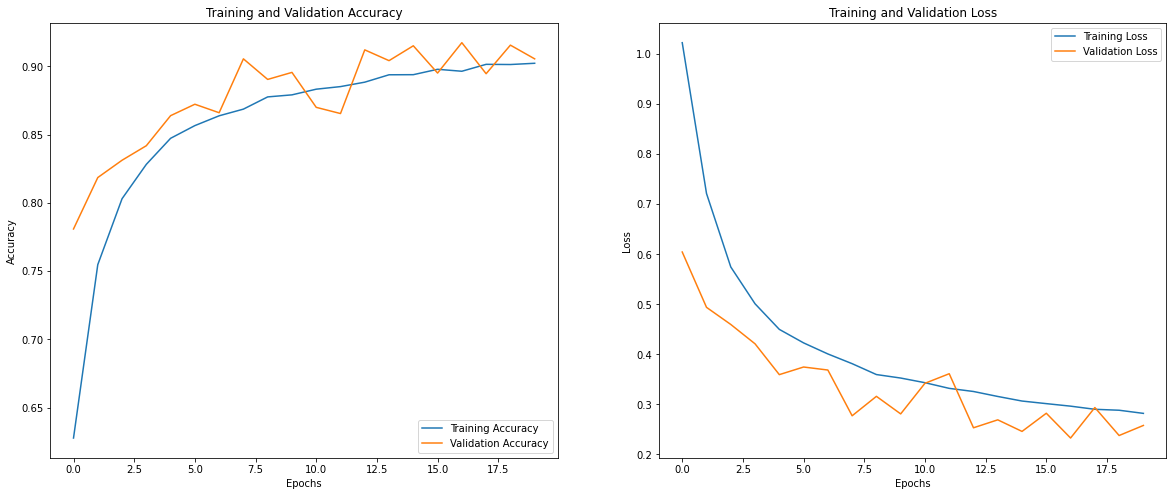

In [28]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# x-axis
epochs_range = range(epochs)

# First figure: Model Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Second figure: Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

The graphs above show a gradual increase in accuracy and decrease in loss. The model does not seem to be overfitting or udnerfitting. The overall results are satisfying with a decently high accuracy rate in the end.

## 09. Model Prediction

We will now be passing in our test dataset to the model to see if the model can accurately diagnose the patient retinal OCT images. 

The following are the predicted class names generated by the model:

In [29]:
class_names = np.array(['CNV', 'DME', 'DRUSEN', 'NORMAL'])

image_batch, label_batch = next(iter(test_data_gen))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['NORMAL' 'CNV' 'DME' 'NORMAL' 'NORMAL' 'DME' 'CNV' 'CNV' 'CNV' 'NORMAL'
 'NORMAL' 'DME' 'CNV' 'CNV' 'DRUSEN' 'DME' 'CNV' 'NORMAL' 'DRUSEN'
 'DRUSEN' 'DME' 'CNV' 'NORMAL' 'CNV' 'CNV' 'NORMAL' 'CNV' 'NORMAL'
 'NORMAL' 'CNV' 'CNV' 'CNV' 'CNV' 'CNV' 'DRUSEN' 'NORMAL' 'NORMAL' 'CNV'
 'CNV' 'NORMAL' 'NORMAL' 'DME' 'DRUSEN' 'CNV' 'DRUSEN' 'CNV' 'NORMAL'
 'CNV' 'NORMAL' 'CNV' 'DME' 'NORMAL' 'CNV' 'NORMAL' 'NORMAL' 'DME'
 'NORMAL' 'CNV' 'CNV' 'CNV' 'DME' 'DME' 'NORMAL' 'DME' 'DME' 'NORMAL'
 'DME' 'NORMAL' 'CNV' 'NORMAL' 'DRUSEN' 'DME' 'DME' 'DRUSEN' 'CNV' 'CNV'
 'CNV' 'NORMAL' 'CNV' 'NORMAL' 'DRUSEN' 'NORMAL' 'CNV' 'DME' 'NORMAL'
 'NORMAL' 'CNV' 'CNV' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'DRUSEN' 'CNV'
 'NORMAL' 'CNV' 'NORMAL' 'CNV' 'DME' 'NORMAL' 'DRUSEN' 'CNV' 'DRUSEN'
 'NORMAL' 'CNV' 'NORMAL' 'NORMAL' 'CNV' 'NORMAL' 'NORMAL' 'NORMAL' 'CNV'
 'CNV' 'CNV' 'NORMAL' 'CNV' 'NORMAL' 'NORMAL' 'DME' 'CNV' 'CNV' 'DRUSEN'
 'CNV' 'CNV' 'CNV' 'NORMAL' 'CNV' 'CNV']


Let's quickly compare the predicted and true labels. 

In [30]:
print("Labels:\n", label_batch.astype('int64'))
print("Predicted labels:\n", predicted_ids)

Labels:
 [2 0 1 3 3 1 0 0 0 3 3 1 0 0 0 1 0 3 2 2 1 0 3 0 0 3 0 3 3 1 0 0 0 0 0 3 3
 0 0 3 3 3 2 0 0 0 3 0 3 0 1 3 0 3 3 1 3 0 0 0 3 1 3 1 1 3 0 3 0 3 2 1 1 0
 0 0 0 3 0 3 2 3 0 1 3 3 0 0 3 3 3 3 2 0 3 0 3 0 1 2 2 0 3 3 0 3 3 0 3 3 3
 0 0 0 3 0 3 3 1 0 0 2 0 0 0 3 0 0]
Predicted labels:
 [3 0 1 3 3 1 0 0 0 3 3 1 0 0 2 1 0 3 2 2 1 0 3 0 0 3 0 3 3 0 0 0 0 0 2 3 3
 0 0 3 3 1 2 0 2 0 3 0 3 0 1 3 0 3 3 1 3 0 0 0 1 1 3 1 1 3 1 3 0 3 2 1 1 2
 0 0 0 3 0 3 2 3 0 1 3 3 0 0 3 3 3 3 2 0 3 0 3 0 1 3 2 0 2 3 0 3 3 0 3 3 3
 0 0 0 3 0 3 3 1 0 0 2 0 0 0 3 0 0]


To get a better sense, we can visualize the first thirty model predictions.

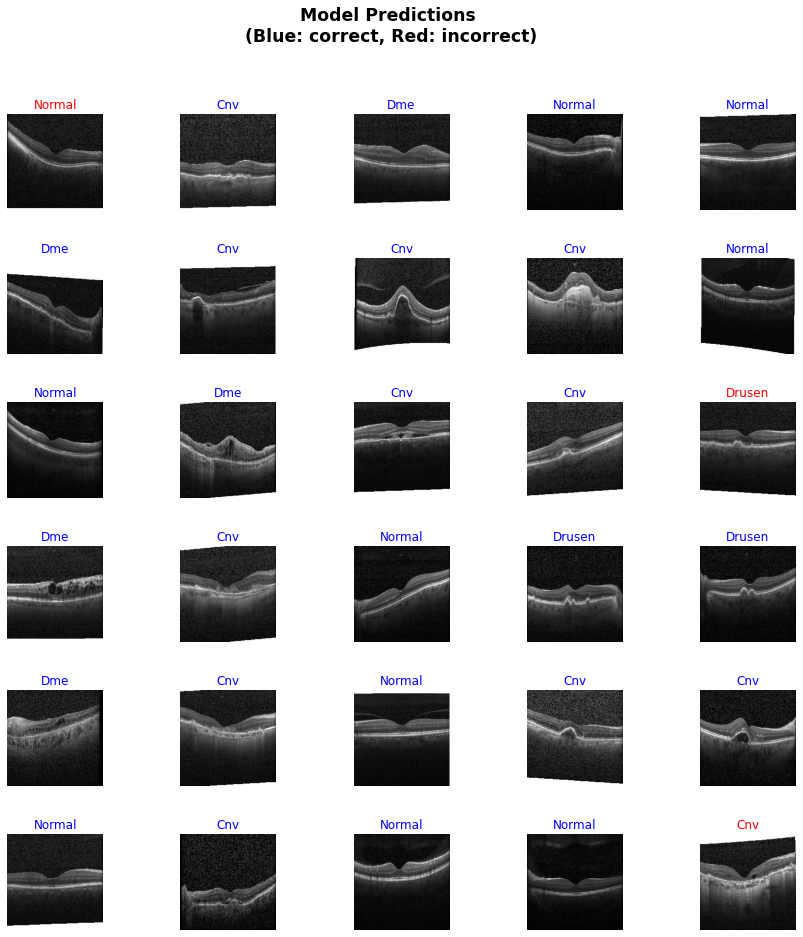

In [31]:
plt.figure(figsize=(15,15))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])

  if predicted_ids[n] == label_batch[n]:
    color = "blue" 
  else:
    color = "red"

  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions\n (Blue: correct, Red: incorrect)", 
                 fontsize='xx-large', fontweight='bold')

In [32]:
acc = model.evaluate(test_data_gen)

66/66 [==============================] - 43s 657ms/step - loss: 0.2734 - accuracy: 0.9000


We can see that our CNN model finished with a **90.00%** accuracy with the test dataset, which are composed of images the model has never seen before. 